In [ ]:
# Install packages

# Remember to Restart runtime after installation


!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!pip install tornado==6.1
!pip install coiled
!pip install torch
!pip install jupyter
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [ ]:
!pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [1]:
# All Imports

#import numpy as np
#import itk
#import vtk
import itkwidgets
#import icon_registration
#import icon_registration.itk_wrapper as itk_wrapper
#import icon_registration.pretrained_models as pretrained_models
from oai_analysis_2 import mesh_processing as mp
from oai_analysis_2 import dask_processing as dp

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

#import boto3
#import coiled
#import dask
#from dask import delayed, compute, visualize
#from dask.distributed import Client, progress, LocalCluster

In [ ]:
# Create the environment

if False:
  coiled.create_software_environment(
    name="oai6",
    pip="coiled_requirements.txt",
  )

In [ ]:
# To create a software environment using docker with open gl installed
# coiled.create_software_environment(
#     name="oai6",
#     container="pranjalsahu/pranjal-sahu-oai6:latest",
# )

Creating new software environment
Creating container-only software environment
Successfully saved software environment build


In [ ]:
# Create Dask Client. This will also spawn dask worker and scheduler

use_coiled = True

if use_coiled:
  name = 'oai-processing'
  cluster = coiled.Cluster(n_workers=2,
                         worker_cpu=8,
                         worker_memory='31G',
                         name=name,
                         software='pranjal-sahu/oai6')
  client = dask.distributed.Client(cluster, 
                                   serializers=['pickle', 'dask'],
                                   deserializers=['pickle', 'dask'])
  client
else:
  cluster = LocalCluster(processes=False)
  client = Client(cluster)
  client

Output()

Using existing cluster: 'oai-processing'

In [ ]:
client

<Client: 'tls://10.0.0.85:8786' processes=2 threads=16, memory=61.48 GiB>

In [ ]:
cluster

In [6]:
# All Function Definitions with Dask Delayed Decorator to perform parallel Computing

@delayed(nout=3)
def register_images_delayed():
    import boto3
    import itk
    import icon_registration
    import icon_registration.itk_wrapper as itk_wrapper
    import icon_registration.pretrained_models as pretrained_models
    from os.path import exists

    if 1:
        image_A = 'image_preprocessed.nii.gz'
        image_B = 'atlas_image.nii.gz'
        if (exists(image_A) and exists(image_B)) == False:
          s3          = boto3.resource("s3")
          bucket_name = 'oaisample1'
          bucket      = s3.Bucket(bucket_name)

          s3.Bucket(bucket_name).download_file(image_A, image_A)
          s3.Bucket(bucket_name).download_file(image_B, image_B)
    else:
        image_A = './OAIData/image_preprocessed.nii.gz'
        image_B = './OAIData/atlas_image.nii.gz'

    image_A = itk.imread(image_A, itk.D)
    image_B = itk.imread(image_B, itk.D)

    model = pretrained_models.OAI_knees_gradICON_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return itk.dict_from_transform(phi_AB), itk.dict_from_image(image_A), itk.dict_from_image(image_B)

@delayed(nout=1)
def deform_probmap_FC_delayed(phi_AB, image_A, image_B):
    import itk
    import boto3

    if 1:
        s3          = boto3.resource("s3")
        bucket_name = 'oaisample1'
        bucket      = s3.Bucket(bucket_name)
        fc_prob_file = 'FC_probmap.nii.gz'
        s3.Bucket(bucket_name).download_file(fc_prob_file, fc_prob_file)

    phi_AB1  = itk.transform_from_dict(phi_AB)
    
    def set_parameters(phi_AB, phi_AB1):
        for i in range(len(phi_AB)-1):
            transform1 = phi_AB1.GetNthTransform(i)

            fp = phi_AB[i+1]['fixedParameters']
            o1 = transform1.GetFixedParameters()
            o1.SetSize(fp.shape[0])
            for j, v in enumerate(fp):
                o1.SetElement(j, v)
            transform1.SetFixedParameters(o1)

            p = phi_AB[i+1]['parameters']
            o2 = transform1.GetParameters()
            o2.SetSize(p.shape[0])
            for j, v in enumerate(p):
                o2.SetElement(j, v)
            transform1.SetParameters(o2)

    set_parameters(phi_AB, phi_AB1)
    image_A = itk.image_from_dict(image_A)
    image_B = itk.image_from_dict(image_B)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    
    prob_file = 'FC_probmap.nii.gz'
    prob = itk.imread(prob_file, itk.D)

    warped_image = itk.resample_image_filter(prob, 
       transform=phi_AB1, 
       interpolator=interpolator,
       size=itk.size(image_B),
       output_spacing=itk.spacing(image_B),
       output_direction=image_B.GetDirection(),
       output_origin=image_B.GetOrigin()
    )

    output_dict = itk.dict_from_image(warped_image)
    return output_dict
  
@delayed
def deform_probmap_delayed(phi_AB, image_A, image_B, image_type ='FC'):
    import itk
    import boto3

    if 1:
        s3          = boto3.resource("s3")
        bucket_name = 'oaisample1'
        bucket      = s3.Bucket(bucket_name)
        fc_prob_file = str(image_type)+'_probmap.nii.gz'
        s3.Bucket(bucket_name).download_file(fc_prob_file, fc_prob_file)

    phi_AB1  = itk.transform_from_dict(phi_AB)
    
    def set_parameters(phi_AB, phi_AB1):
        for i in range(len(phi_AB)-1):
            transform1 = phi_AB1.GetNthTransform(i)

            fp = phi_AB[i+1]['fixedParameters']
            o1 = transform1.GetFixedParameters()
            o1.SetSize(fp.shape[0])
            for j, v in enumerate(fp):
                o1.SetElement(j, v)
            transform1.SetFixedParameters(o1)

            p = phi_AB[i+1]['parameters']
            o2 = transform1.GetParameters()
            o2.SetSize(p.shape[0])
            for j, v in enumerate(p):
                o2.SetElement(j, v)
            transform1.SetParameters(o2)

    set_parameters(phi_AB, phi_AB1)
    image_A = itk.image_from_dict(image_A)
    image_B = itk.image_from_dict(image_B)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    
    prob_file = str(image_type)+'_probmap.nii.gz'
    prob = itk.imread(prob_file, itk.D)

    warped_image = itk.resample_image_filter(prob, 
       transform=phi_AB1, 
       interpolator=interpolator,
       size=itk.size(image_B),
       output_spacing=itk.spacing(image_B),
       output_direction=image_B.GetDirection(),
       output_origin=image_B.GetOrigin()
    )

    output_dict = itk.dict_from_image(warped_image)
    return output_dict
    

@delayed(nout=1)
def get_thickness(warped_image, mesh_type):
    import itk
    import vtk
    import numpy as np
    from oai_analysis_2 import mesh_processing as mp

    def get_itk_mesh(vtk_mesh):
        Dimension = 3
        PixelType = itk.D
        
        # Get points array from VTK mesh
        points = vtk_mesh.GetPoints().GetData()
        points_numpy = np.array(points).flatten()#.astype('float32')
            
        polys = vtk_mesh.GetPolys().GetData()
        polys_numpy = np.array(polys).flatten()

        # Triangle Mesh
        vtk_cells_count = vtk_mesh.GetNumberOfPolys()
        polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

        # Extracting only the points by removing first column that denotes the VTK cell type
        polys_numpy = polys_numpy[:, 1:]
        polys_numpy = polys_numpy.flatten().astype(np.uint64)

        # Get point data from VTK mesh to insert in ITK Mesh
        point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
        
        # Get cell data from VTK mesh to insert in ITK Mesh
        cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
        
        MeshType = itk.Mesh[PixelType, Dimension]
        itk_mesh = MeshType.New()
        
        itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
        itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
        itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
        itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
        return itk_mesh

    warped_image = itk.image_from_dict(warped_image)
    distance_inner, distance_outer = mp.get_thickness_mesh(warped_image, mesh_type=mesh_type)
    
    polys = distance_inner.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    distance_inner_itk = get_itk_mesh(distance_inner)
    distance_inner_itk_dict = itk.dict_from_mesh(distance_inner_itk)

    return distance_inner_itk_dict

NameError: name 'delayed' is not defined

In [ ]:
# For checking if vtk import works properly

@delayed
def check_vtk():
  import vtk
  return vtk.__version__

@delayed
def check_skimage():
  import skimage
  return skimage.__version__

t1 = check_skimage()
output_result = compute(t1)
print(output_result)

('0.18.3',)


In [2]:
from dask import compute, visualize

In [ ]:
# Main execution block

phi_AB, image_A, image_B = dp.register_images_delayed()
deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'FC')
deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'TC')

thickness_fc = dp.get_thickness(deformed_fc, 'FC')
thickness_tc = dp.get_thickness(deformed_tc, 'TC')

result = [thickness_fc, thickness_tc]
output_result = compute(*result)

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


In [7]:
phi_AB, image_A, image_B = dp.register_images_delayed()
deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'FC')
deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'TC')

thickness_fc = dp.get_thickness(deformed_fc, 'FC')
thickness_tc = dp.get_thickness(deformed_tc, 'TC')

result = [thickness_fc, thickness_tc]

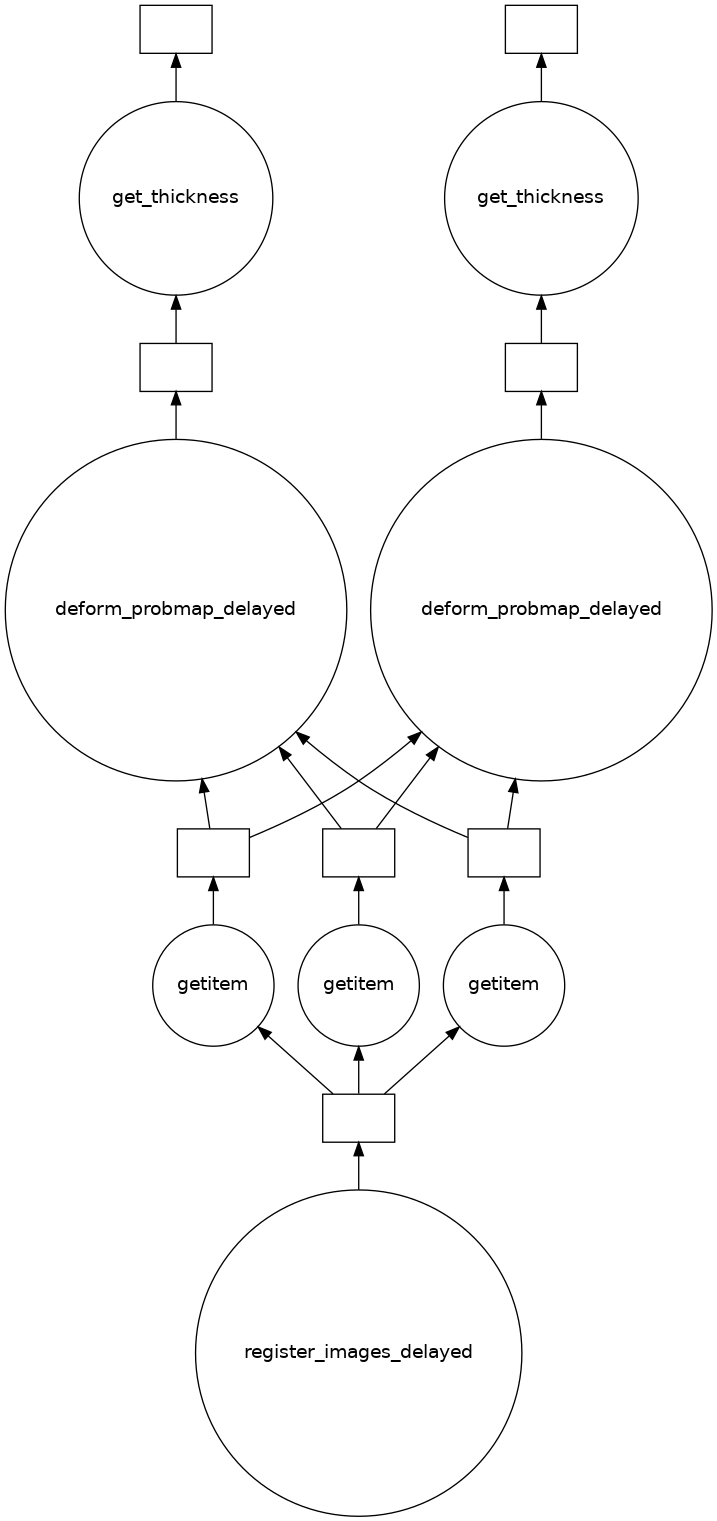

In [8]:
# Visualize Dask Computation Graph

visualize(result)

In [ ]:
# Write the meshes as vtk files

m1 = itk.mesh_from_dict(output_result[0])
m2 = itk.mesh_from_dict(output_result[1])

itk.meshwrite(m1, 'm1.vtk')
itk.meshwrite(m2, 'm2.vtk')

In [ ]:
# Read the meshes for viewing

v1 = vtk.vtkPolyDataReader()
v1.SetFileName('m1.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName('m2.vtk')
v2.Update()
m2 = v2.GetOutput()

In [ ]:
#Visualize the meshes

from google.colab import output
output.enable_custom_widget_manager()

itkwidgets.view(geometries=[m1])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

itkwidgets.view(geometries=[m2])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# Close the cluster and free the resources

cluster.close()